# Predicting costs using case mix index

Date created: 2/27/23 <br>
Last updated: 4/5/23 <br>

**Table of Contents** <br>
0 Inputs and setup <br>
1 Extract costs and DRG weight data <br>
2 Data cleaning and subsetting <br>
3 Statistical analysis <br>
4 Upload clean DRG-cost data to BigQuery


**Assumptions**
* Must be connected to Full Traffic VPN
* LOS is calculated as discharge date - admit date (so an admission and discharge on the same day has LOS = 0)
* 3/14/23 - Remove organ acquisition costs for MS-DRG per https://www.cms.gov/Outreach-and-Education/Medicare-Learning-Network-MLN/MLNMattersArticles/downloads/MM11087.pdf
* May need to run % pip install openpyxl

## 0 Inputs and setup
### 0.1 Global variables

In [2]:
# Your local home directory @@@ Update for your own gcloud JSON file path
user_id = 'grolleau'

# Source data projects and datasets
nero_gcp_project = 'som-nero-phi-jonc101-secure' 
cdm_project_id = 'som-nero-phi-jonc101'
cdm_dataset_id = 'shc_core_2021'

# NERO project and dataset where you are saving your data
work_project_id = nero_gcp_project
work_dataset_id = 'proj_IP_variation'

# Constants
eps = 1e-6 # for zero threshold
date_range = 5 # for difference in admission date
days_per_year = 365.25

# CPI for inflation (source: Annual averages from https://data.bls.gov/timeseries/CUUR0000SAM?output_view=data; series CUUR0000SAM)
# @@@ Table 1
cpi = {2019: 498.413, 
       2020: 518.876, 
       2021: 525.276}
base_year = 2021

# Control variables
run_BQ_upload = 0

### 0.2 Setup environment / credentials

In [3]:
from google.cloud import bigquery
import os
import pandas as pd
import sys
import yaml
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
# GCP credentials for Mac: Ran steps linked here to create JSON credentials and file path (https://github.com/HealthRex/CDSS/blob/master/scripts/DevWorkshop/ReadMe.GoogleCloud-BigQuery-VPC.txt)
# @@@ Update for your own gcloud JSON file path
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = (
    f'/Users/{user_id}/.config/gcloud/application_default_credentials.json'
)
os.environ['GCLOUD_PROJECT'] = nero_gcp_project

# Use Francois' credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/grolleau/Desktop/github repos/Cost variability/json_credentials/grolleau_application_default_credentials.json'
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-jonc101-secure'

# Instantiate a client object so you can make queries
client = bigquery.Client()

## 1 Extract costs and DRG weight data

### 1.1 Cost data

In [14]:
query= """
    SELECT 
        b.anon_id,
        a.AdmitDate + b.jitter as adm_date_jittered,
        a.DischargeDate + b.jitter as disch_date_jittered,
        EXTRACT(YEAR FROM a.DischargeDate) AS discharge_year,
        a.MSDRGWeight,
        a.Cost_Direct_Scaled,
        a.Cost_Breakdown_OrganAcq_Scaled
    FROM `{nero_gcp_project}.shc_cost.costUB` a
    LEFT JOIN `{nero_gcp_project}.starr_map.shc_map_2021` b
    ON LPAD(CAST(a.mrn AS string), 8, '0') = b.mrn
    WHERE a.Inpatient_C = 'I'
""".format_map({'nero_gcp_project': nero_gcp_project})

In [15]:
print(query)


    SELECT 
        b.anon_id,
        a.AdmitDate + b.jitter as adm_date_jittered,
        a.DischargeDate + b.jitter as disch_date_jittered,
        EXTRACT(YEAR FROM a.DischargeDate) AS discharge_year,
        a.MSDRGWeight,
        a.Cost_Direct_Scaled,
        a.Cost_Breakdown_OrganAcq_Scaled
    FROM `som-nero-phi-jonc101-secure.shc_cost.costUB` a
    LEFT JOIN `som-nero-phi-jonc101-secure.starr_map.shc_map_2021` b
    ON LPAD(CAST(a.mrn AS string), 8, '0') = b.mrn
    WHERE a.Inpatient_C = 'I'



In [ ]:

cost_data = client.query(query).to_dataframe()

In [5]:
# View data and adjust for inflation to 2021 using Medical Care CPI
cost_data['CPI'] = cost_data['discharge_year'].map(cpi)
cost_data['Cost_Adj'] = (cost_data['Cost_Direct_Scaled'].subtract(cost_data['Cost_Breakdown_OrganAcq_Scaled'], fill_value = 0)).astype(float) * cpi[base_year] / cost_data['CPI']
# cost_data

In [10]:
# Distinct patient IDs in cost data (done separately to avoid saving MRNs)
# Calculate date range
query= """
    SELECT 
        COUNT(DISTINCT mrn) as ct,
        MIN(AdmitDate) as min_dt,
        MAX(DischargeDate) as max_dt
    FROM `{nero_gcp_project}.shc_cost.costUB` a
    WHERE Inpatient_C = 'I'
""".format_map({'nero_gcp_project': nero_gcp_project})

costdata_summary = client.query(query).to_dataframe()

In [11]:
print(query)


    SELECT 
        COUNT(DISTINCT mrn) as ct,
        MIN(AdmitDate) as min_dt,
        MAX(DischargeDate) as max_dt
    FROM `som-nero-phi-jonc101-secure.shc_cost.costUB` a
    WHERE Inpatient_C = 'I'



In [7]:
ct_pt_cost = costdata_summary['ct']
costdata_summary

,ct,min_dt,max_dt
0,38443,2019-03-13,2021-08-31


### 1.2 DRG data

In [12]:
# Get range of discharge years to pull DRG codes
min_year = min(cost_data['discharge_year'])

# Query for DRG codes in cost time range
query= """
    SELECT DISTINCT
        a.anon_id, 
        a.pat_enc_csn_id_jittered as observation_id,
        a.hosp_adm_date_jittered as adm_date,
        a.hosp_disch_date_jittered as disch_date,
        b.drg_mpi_code,
        b.drg_id,
        b.drg_name,
        b.DRG_CODE_SET_C,
        b.drg_weight
    FROM `{cdm_project_id}.{cdm_dataset_id}.f_ip_hsp_admission` a
    LEFT JOIN `{cdm_project_id}.{cdm_dataset_id}.drg_code` b
    ON a.anon_id = b.anon_id AND a.pat_enc_csn_id_jittered = b.pat_enc_csn_id_coded
    WHERE EXTRACT(YEAR FROM a.hosp_disch_date_jittered) >= {min_year}
""".format_map({'cdm_project_id': cdm_project_id,
                'cdm_dataset_id': cdm_dataset_id,
                'min_year': min_year})

In [ ]:

drg_data = client.query(query).to_dataframe()

In [9]:
# Total encounter counts
drg_data.drop_duplicates(subset=['observation_id']).shape[0]

102242

In [10]:
# Test counts for one DRG
test_drg = drg_data[(drg_data['drg_mpi_code']=='301') & (drg_data['DRG_CODE_SET_C']=='51')]
test_drg['year'] = pd.to_datetime(test_drg['disch_date']).dt.year
# type(pd.to_datetime(test_drg['adm_date']))

test_drg_sum = test_drg.drop_duplicates(subset=['observation_id']).groupby(['year']).agg(
    N_adm = ('observation_id', "count")  # Number of admissions
)
test_drg_sum

/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/354288693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_drg['year'] = pd.to_datetime(test_drg['disch_date']).dt.year


,N_adm
year,
2019,890
2020,736
2021,296


## 2 Data cleaning and subsetting

### 2.1 Cost data

In [11]:
# Create modifiable dataset with unique ID for each admission
cost_data_filtered = cost_data.copy()
cost_data_filtered["observation_id"] = cost_data_filtered["anon_id"].astype('str') + "_" + cost_data_filtered["adm_date_jittered"].astype('str')
cost_data_filtered["LOS"] = (cost_data_filtered["disch_date_jittered"] - cost_data_filtered["adm_date_jittered"]).dt.days

# Check for duplicates
dups = cost_data_filtered[cost_data_filtered.duplicated(subset=['observation_id'], keep=False)].sort_values(by=['anon_id', 'adm_date_jittered'])
# print(dups)
# There are 4 patients with 2 admissions that started on the same day, although the discharge dates and sometimes the DRG weights are different.
# These patients all have 1 single-day admission among the duplicates.

# Check for zeros
# cost_data_filtered.loc[cost_data_filtered['MSDRGWeight'] < eps]

In [12]:
# Check for patients without mapped anon_ID
# cost_data_filtered[cost_data_filtered['anon_id'].isnull()]

In [13]:
# Remove duplicates and MSDRG Weights of 0
cost_data_filtered = cost_data_filtered[cost_data_filtered['anon_id'].notnull() & cost_data_filtered['MSDRGWeight'] > eps]
# cost_data_filtered

### 2.2 DRG data

In [14]:
# Merge DRGs to costs on patient ID, admission, and discharge date
drg_costs = cost_data_filtered.merge(drg_data, how='left', left_on=['anon_id', 'adm_date_jittered', 'disch_date_jittered'], right_on=['anon_id', 'adm_date', 'disch_date'])
drg_costs = drg_costs.rename(columns={"observation_id_y": "observation_id"})
# drg_costs

In [15]:
# Filter to exact date matches and flag exact DRG weight matches
exact_matches = drg_costs[drg_costs['observation_id'].notnull()]
exact_matches['flag_drgwt_match'] = abs(exact_matches['MSDRGWeight'] - exact_matches['drg_weight']) < eps
exact_matches['match_step'] = exact_matches['flag_drgwt_match'].astype(int)
# exact_matches

/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/2334852615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exact_matches['flag_drgwt_match'] = abs(exact_matches['MSDRGWeight'] - exact_matches['drg_weight']) < eps
/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/2334852615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exact_matches['match_step'] = exact_matches['flag_drgwt_match'].astype(int)


In [16]:
# Check admissions without a match in the DRG/clinical data ~ 10,000
non_matched = drg_costs[drg_costs['observation_id'].isnull()]

# Check if these admissions have other match in DRG data (non-exact date matches): seeing more matches captured but admit/discharge dates mismatched by a little bit
non_matched_try1 = non_matched.loc[:,'anon_id':'LOS'].merge(drg_data, how='left', on='anon_id')
non_matched_try1

# How many patients without a match at all? <50; Looked at 2 examples and did not find them in either the IP date or DRG dataset used in the clinical data query above
non_matched_try1[non_matched_try1['observation_id'].isnull()]

# Drop admissions without any patient ID match or already matched, and flag close dates
non_matched_try2 = non_matched_try1[non_matched_try1['observation_id'].notnull()]
non_matched_try2 = non_matched_try2[~non_matched_try2['observation_id'].isin(exact_matches[exact_matches['match_step'] == 1]['observation_id'])]
non_matched_try2['flag_drgwt_match'] = abs(non_matched_try2['MSDRGWeight'] - non_matched_try2['drg_weight']) < eps
non_matched_try2['flag_close_dates'] = (np.abs((non_matched_try2['adm_date_jittered'] - non_matched_try2['adm_date']).dt.days) < date_range) # Warning should be ok, probably relates to recursive nature of this line
non_matched_try2['match_step'] = (non_matched_try2['flag_close_dates'] & non_matched_try2['flag_drgwt_match']).astype(int) * 2 # 2 if approximate match, 0 otherwise
non_matched_try2

# Combine 
#drg_costs_filtered = exact_matches.append(non_matched_try2.drop(columns = ['flag_close_dates']))
# drg_costs_filtered
drg_costs_filtered = pd.concat([exact_matches, non_matched_try2.drop(columns = ['flag_close_dates'])])

In [17]:
# Test matched counts for one DRG
test_matched_drg_data = drg_costs_filtered[drg_costs_filtered['match_step'] > 0] # all matched data
test_drg_matched = test_matched_drg_data[(test_matched_drg_data['drg_mpi_code']=='301') & (test_matched_drg_data['DRG_CODE_SET_C']=='51')]
test_drg_matched['year'] = pd.to_datetime(test_drg_matched['disch_date']).dt.year

test_drg_matched_sum = test_drg_matched.drop_duplicates(subset=['observation_id']).groupby(['year']).agg(
    N_adm = ('observation_id', "count")  # Number of admissions
)
test_drg_matched_sum

/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/3734358647.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_drg_matched['year'] = pd.to_datetime(test_drg_matched['disch_date']).dt.year


,N_adm
year,
2019,247
2020,461


In [18]:
# Look for non-matched encounters with DRG that were matched for different (similar) DRG
test_drg_non_matched = test_drg[~test_drg['observation_id'].isin(test_drg_matched['observation_id'])]
test_drg_other_matched = test_drg_non_matched[test_drg_non_matched['observation_id'].isin(test_matched_drg_data['observation_id'])]

# test_drg_non_matched[test_drg_non_matched['year']==2020]
test_drg_other_matched.drop_duplicates(subset=['observation_id']).groupby(['year']).agg(
    N_adm = ('observation_id', "count")  # Number of admissions
)

,N_adm
year,
2020,146
2021,258


In [19]:
# Look into Bigquery for some patients whose DRG data had no corresponding cost data
test_drg_non_matched2 = test_drg_non_matched[~test_drg_non_matched['observation_id'].isin(test_drg_other_matched['observation_id'])]

# test_close_dates = exact_matches.append(non_matched_try2[non_matched_try2['flag_close_dates'] > 0])

test_drg_non_matched_id = test_drg_non_matched2[~test_drg_non_matched2['anon_id'].isin(cost_data_filtered['anon_id'])]

# test_drg_non_matched[test_drg_non_matched['year']==2020]
test_drg_non_matched_id.drop_duplicates(subset=['observation_id']).groupby(['year']).agg(
    N_adm = ('observation_id', "count")  # Number of admissions
)

,N_adm
year,
2019,550
2020,127
2021,33


### 2.3 Flowchart of data filtering process
* Admissions with cost data
* With mapped ID
* With DRG codes in clinical data
    * Matched with exact admit and discharge dates
    * Matched with approximate admit and discharge dates
* Exclude duplicates

In [20]:
# Admission counts
ct_adm_1 = cost_data.drop_duplicates().shape[0]
ct_adm_2 = cost_data_filtered.shape[0]
ct_adm_3 = drg_costs_filtered[drg_costs_filtered['match_step']>0].drop_duplicates(subset = 'observation_id').shape[0]
ct_adm_3a = drg_costs_filtered[drg_costs_filtered['match_step']==1].drop_duplicates(subset = 'observation_id').shape[0]
ct_adm_3b = drg_costs_filtered[drg_costs_filtered['match_step']==2].drop_duplicates(subset = 'observation_id').shape[0]

# Patient counts
ct_pt_1 = costdata_summary['ct'][0]
ct_pt_2 = cost_data.drop_duplicates(subset = 'anon_id').shape[0]
ct_pt_3 = drg_costs_filtered[drg_costs_filtered['match_step']>0].drop_duplicates(subset = 'anon_id').shape[0]
ct_pt_3a = drg_costs_filtered[drg_costs_filtered['match_step']==1].drop_duplicates(subset = 'anon_id').shape[0]
ct_pt_3b = drg_costs_filtered[drg_costs_filtered['match_step']==2].drop_duplicates(subset = 'anon_id').shape[0]



df = {' ': pd.Series(['With cost data', 'And mapped ID', 'And DRG codes in clinical data', '==== Matched with exact admit date, discharge date, and DRG weight', '==== Matched with exact DRG weight and approximate admit and discharge dates']),
    'Admission count': pd.Series([ct_adm_1, ct_adm_2, ct_adm_3, ct_adm_3a, ct_adm_3b]),
    '% of above': pd.Series([1, ct_adm_2/ct_adm_1, ct_adm_3/ct_adm_2, ct_adm_3a/ct_adm_3, ct_adm_3b/ct_adm_3]),
    'Patient count': pd.Series([ct_pt_1, ct_pt_2, ct_pt_3, ct_pt_3a, ct_pt_3b]),
    '% of above ': pd.Series([1, ct_pt_2/ct_pt_1, ct_pt_3/ct_pt_2, ct_pt_3a/ct_pt_3, ct_pt_3b/ct_pt_3]),
     }
flowchart = pd.DataFrame(df)
flowchart.style.format({"Admission count": "{:,.0f}", "% of above": "{:,.2%}", "Patient count": "{:,.0f}", "% of above ": "{:,.2%}"}).set_properties(subset=[' '], **{'text-align': 'left'})

# @@@ Methods section - "54,316 inpatient admissions among 37,360 unique patients" (3rd line of table below)

,,Admission count,% of above,Patient count,% of above
0,With cost data,"56,149",100.00%,"38,443",100.00%
1,And mapped ID,"55,962",99.67%,"38,326",99.70%
2,And DRG codes in clinical data,"54,316",97.06%,"37,360",97.48%
3,"==== Matched with exact admit date, discharge date, and DRG weight","44,178",81.34%,"32,222",86.25%
4,==== Matched with exact DRG weight and approximate admit and discharge dates,"10,138",18.66%,"8,675",23.22%


In [21]:
# Sanity checks for duplicates
# cost_data_filtered.drop_duplicates().shape[0] == cost_data_filtered.shape[0]

## 3 Statistics

### 3.1 Explanatory power of MS-DRG weight for costs in matched DRG-cost data

In [22]:
# Among inpatient cost data with corresponding clinical DRG data
matched_drg_data = drg_costs_filtered[drg_costs_filtered['match_step'] > 0]
matched_drg_data_dedup = matched_drg_data.drop_duplicates(subset=['observation_id'])
matched_drg_data_dedup

# Rescale by median cost
import statistics
med_cost = statistics.mean(matched_drg_data_dedup['Cost_Adj'])
matched_drg_data['Cost_Adj'] = matched_drg_data['Cost_Adj']/med_cost
matched_drg_data_dedup['Cost_Adj'] = matched_drg_data_dedup['Cost_Adj']/med_cost

/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/2329277713.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_drg_data['Cost_Adj'] = matched_drg_data['Cost_Adj']/med_cost
/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/2329277713.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_drg_data_dedup['Cost_Adj'] = matched_drg_data_dedup['Cost_Adj']/med_cost


In [23]:
# Patients with repeat hospitalizations
obs_id_ct = matched_drg_data.groupby('anon_id')['observation_id'].nunique()
len(obs_id_ct[obs_id_ct > 1])/len(obs_id_ct)

0.24004282655246253

In [24]:
# Check if multiple different DRGs - none???!
check_multiple_drgs = matched_drg_data.drop_duplicates(subset=['anon_id', 'observation_id', 'drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).groupby(['anon_id', 'observation_id', 'DRG_CODE_SET_C']).agg(
    N_drg = ('drg_mpi_code', "count")  # Number of different drgs per code set?
)
check_multiple_drgs[~check_multiple_drgs['N_drg']==1]

,,,N_drg
anon_id,observation_id,DRG_CODE_SET_C,


In [25]:
# Check number of obs with multiple or one DRG system
check_multiple_drg_sys = matched_drg_data.drop_duplicates(subset=['observation_id', 'drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).groupby(['observation_id']).agg(
    N_drg_sys = ('DRG_CODE_SET_C', "count")  # Number of different drgs per code set?
)
print(sum(check_multiple_drg_sys['N_drg_sys']==1))
print(sum(check_multiple_drg_sys['N_drg_sys']>1))

2
54314


In [26]:
# Run statistical analysis - @@@ Table 2: See R-squared value at top right of results summary and intercept/coefficients + 95% CIs in 2nd box
y_matched = matched_drg_data_dedup['Cost_Adj'][matched_drg_data_dedup['MSDRGWeight'] > eps].astype(float).to_numpy()
X_matched = matched_drg_data_dedup['MSDRGWeight'][matched_drg_data_dedup['MSDRGWeight'] > eps].astype(float).to_numpy()
X_matched = sm.add_constant(X_matched)

est_matched = sm.OLS(y_matched, X_matched)
est_matched = est_matched.fit(cov_type='HC0') # HC0 for heteroskedasticity 
est_matched.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     1038.
Date:                Mon, 13 May 2024   Prob (F-statistic):          1.42e-225
Time:                        13:02:58   Log-Likelihood:                -90878.
No. Observations:               54316   AIC:                         1.818e+05
Df Residuals:                   54314   BIC:                         1.818e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1328      0.023      5.727      0.000       0.087       0.178
x1             0.3325      0.010     32.216      0.000       0.312       0.353
==============================================================================
Omnibus:                    96252.176   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        327798603.439
Skew:                          12.326   Prob(JB):                         0.00
Kurtosis:                     382.780   Cond. No.                         5.41
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [27]:
# Bootstrap R^2 
from random import choices
rsquared_boot, coefs_boot, sims = [], [], 1000

# Run 1K iterations - this takes a while to run
for i in range(sims):
    # First create a bootstrap sample with replacement with n=df.shape[0]
    bootstrap = choices(range(X_matched.shape[0]), k = X_matched.shape[0])
    y_matched_bs = y_matched[bootstrap]
    X_matched_bs = X_matched[bootstrap, :]
    # Fit the regression and append the r square to rsquared_boot
    rsquared_boot.append(sm.OLS(y_matched_bs, X_matched_bs).fit(cov_type='HC0').rsquared)


In [28]:
# @@@ Calculate 95% CI on rsquared_boot - didn't set seed, so may vary from published result due to random variation
r_sq_95_ci = np.percentile(a=rsquared_boot, q=[2.5, 97.5])
print("R Squared 95% CI = {}".format(r_sq_95_ci))

R Squared 95% CI = [0.34932039 0.39937018]


In [29]:
# Bootstrap histogram
# plt.hist(rsquared_boot)

### 3.2 Variation in costs by DRG

In [30]:
# For matched DRG codes, get predicted cost from the model above
# matched_drg_data = drg_costs_filtered[drg_costs_filtered['match_step'] > 0]
# matched_drg_data = matched_drg_data[matched_drg_data['MSDRGWeight'] > eps]
X_predict = sm.add_constant(matched_drg_data['MSDRGWeight'].astype(float).to_numpy())
predicted_cost = est_matched.predict(X_predict)
matched_drg_data['Cost_Predicted'] = predicted_cost
matched_drg_data['Cost_Residual'] = matched_drg_data['Cost_Adj'].astype(float) - matched_drg_data['Cost_Predicted']
matched_drg_data['Cost_Residual_sq'] = matched_drg_data['Cost_Residual'] ** 2

# Admissions, Mean_SD of DRG weight, Total cost scaled by total hosp cost, Total residual scaled by total hosp cost
matched_drg_summary = matched_drg_data.drop_duplicates(subset=['observation_id', 'drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).groupby(['drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).agg(
    N_adm = ('observation_id', "count"),  # Number of admissions
    Mean_wt = ('MSDRGWeight', "mean"),  
    Std_wt = ('MSDRGWeight', "std"),  
    Total_cost = ('Cost_Adj', sum),
    Total_residual =('Cost_Residual', sum)  
#     Total_RSS =('Cost_Residual_sq', sum),  
)
matched_drg_summary = matched_drg_summary.sort_values(by=['Total_residual'], ascending=False)

/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/3209878436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_drg_data['Cost_Predicted'] = predicted_cost
/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/3209878436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_drg_data['Cost_Residual'] = matched_drg_data['Cost_Adj'].astype(float) - matched_drg_data['Cost_Predicted']
/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/3209878436.py:8: Settin

In [31]:
# Output patient-level data to Excel
pt_data = matched_drg_data[['anon_id', 'observation_id', 'MSDRGWeight', 'drg_id', 'drg_mpi_code', 'DRG_CODE_SET_C', 'drg_name', 'Cost_Adj', 'Cost_Predicted']]

# pt_data.to_excel("IP_variation_data.xlsx", sheet_name='Pt_level') 

In [32]:
# Calculate DRG-level data, output to Excel
drg_lvl_data = matched_drg_data.drop_duplicates(subset=['observation_id', 'drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).groupby(['drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).agg(
    N_adm = ('observation_id', "count"),  # Number of admissions
    Total_cost = ('Cost_Adj', sum),
    Min_cost = ('Cost_Adj', min),
    Max_cost = ('Cost_Adj', max),
    Mean_cost = ('Cost_Adj', "mean"),
    SD_cost = ('Cost_Adj', "std"),
    Mean_wt = ('MSDRGWeight', "mean"),  
    SD_wt = ('MSDRGWeight', "std"),  
    Total_residual =('Cost_Residual', sum), 
    Mean_residual =('Cost_Residual', "mean"), 
    SD_residual = ('Cost_Residual', "std"),  
    RSS =('Cost_Residual_sq', sum),  
)

# Calculate total sum of squares
drg_lvl_data['TSS'] = (drg_lvl_data['SD_cost']**2)*drg_lvl_data['N_adm']

# Annualize totals by dividing by number of years
year_range = (costdata_summary['max_dt'] - costdata_summary['min_dt']).dt.days / days_per_year
drg_lvl_data['N_adm'] = drg_lvl_data['N_adm'].astype('float').div(year_range[0], level=1)
drg_lvl_data['Total_cost'] = drg_lvl_data['Total_cost'].div(year_range[0], level=1)
drg_lvl_data['Total_residual'] = drg_lvl_data['Total_residual'].div(year_range[0], level=1)

drg_lvl_data = drg_lvl_data.sort_values(by=['Total_residual'], ascending=False)

drg_lvl_data

# with pd.ExcelWriter('IP_variation_data.xlsx',
#                     mode='a') as writer:  
#     drg_lvl_data.to_excel(writer, sheet_name='DRG_level')

with pd.ExcelWriter('IP_variation_data.xlsx') as writer:  
    pt_data.to_excel(writer, sheet_name='encounter_level')
    drg_lvl_data.to_excel(writer, sheet_name='DRG_level')

/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/3746625642.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  drg_lvl_data = matched_drg_data.drop_duplicates(subset=['observation_id', 'drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).groupby(['drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).agg(
/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/3746625642.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  drg_lvl_data = matched_drg_data.drop_duplicates(subset=['observation_id', 'drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).groupby(['drg_name', 'drg_mpi_code', 'DRG_CODE_SET_C']).agg(
/var/f

In [33]:
# Sorted by highest excess cost - @@@ Included in Table 3 + 4
matched_drg_summary.loc[(slice(None), slice(None), ['6']),:].iloc[:10] # Only include MS-DRGs
matched_drg_summary.iloc[:30] # All DRGs

,,,N_adm,Mean_wt,Std_wt,Total_cost,Total_residual
drg_name,drg_mpi_code,DRG_CODE_SET_C,,,,,
"ECMO OR TRACHEOSTOMY WITH MV >96 HOURS OR PRINCIPAL DIAGNOSIS EXCEPT FACE, MOUTH AND NECK WITH MAJOR O.R. PROCEDURES",003,6,251,18.9218,0.158405,2214.785395,602.258418
PSYCHOSES,885,6,1112,1.223611,0.012161,966.355454,366.260682
AUTOLOGOUS BONE MARROW TRANSPLANT WITH CC/MCC,016,6,366,6.810491,0.096556,1238.815034,361.393898
LIVER TRANSPLANT AND/OR INTESTINAL TRANSPLANT,001,3,159,10.005216,2.455783,825.836564,275.761530
HEART AND/OR LUNG TRANSPLANT,002,3,197,21.101384,7.921717,1650.975756,242.596110
IMPLANTABLE HEART ASSIST SYSTEMS,161,3,28,23.627136,8.484201,453.996682,230.305710
OTHER CARDIOTHORACIC AND THORACIC VASCULAR PROCEDURES,167,3,452,6.283437,3.037302,1231.756285,227.377530
SEPTICEMIA AND DISSEMINATED INFECTIONS,720,3,2746,2.091227,1.468214,2500.670307,226.593982
INFECTIOUS AND PARASITIC DISEASES INCLUDING HIV WITH O.R. PROCEDURE,710,3,376,5.03692,3.033094,898.864471,219.205963


In [34]:
# Sorted by highest excess cost - APR-DRGs - @@@ Included in Table 3 + 4
matched_drg_summary.loc[(slice(None), slice(None), ['3']),:].iloc[:10] # Only include APR-DRGs

,,,N_adm,Mean_wt,Std_wt,Total_cost,Total_residual
drg_name,drg_mpi_code,DRG_CODE_SET_C,,,,,
LIVER TRANSPLANT AND/OR INTESTINAL TRANSPLANT,001,3,159,10.005216,2.455783,825.836564,275.761530
HEART AND/OR LUNG TRANSPLANT,002,3,197,21.101384,7.921717,1650.975756,242.596110
IMPLANTABLE HEART ASSIST SYSTEMS,161,3,28,23.627136,8.484201,453.996682,230.305710
OTHER CARDIOTHORACIC AND THORACIC VASCULAR PROCEDURES,167,3,452,6.283437,3.037302,1231.756285,227.377530
SEPTICEMIA AND DISSEMINATED INFECTIONS,720,3,2746,2.091227,1.468214,2500.670307,226.593982
INFECTIOUS AND PARASITIC DISEASES INCLUDING HIV WITH O.R. PROCEDURE,710,3,376,5.03692,3.033094,898.864471,219.205963
CARDIAC CATHETERIZATION FOR OTHER NON-CORONARY CONDITIONS,192,3,353,1.852362,1.085959,456.537892,192.240734
MAJOR HEMATOLOGIC OR IMMUNOLOGIC DIAGNOSES EXCEPT SICKLE CELL CRISIS AND COAGULATION,660,3,566,1.531229,0.458183,553.842254,190.505008
CARDIAC VALVE PROCEDURES WITH AMI OR COMPLEX PRINCIPAL DIAGNOSIS,162,3,170,8.51908,3.068523,691.057647,186.932517


In [35]:
# Sorted by most negative residual
# matched_drg_summary.loc[(slice(None), slice(None), ['6']),:].sort_values(by=['Total_residual']).iloc[:30] # MS-DRGs only
# matched_drg_summary.sort_values(by=['Total_residual']).iloc[:30] # All DRGs

In [36]:
# Sorted by total cost to check against Kush Gupta's results
# matched_drg_summary.loc[(slice(None), slice(None), ['6']),:].sort_values(by=['Total_cost'], ascending=False).iloc[:20]

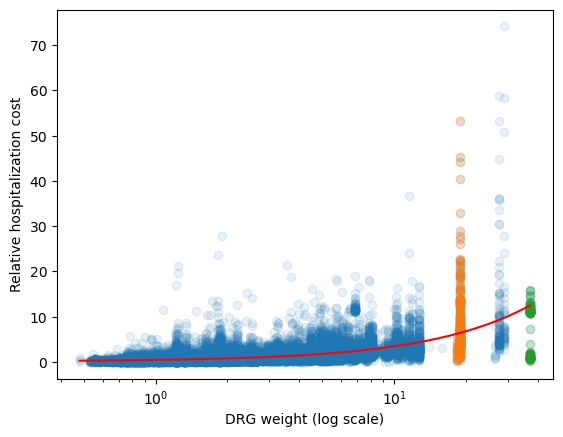

In [37]:
# Plot log scale - @@@ Figure 1
# Plot all costs with DRG subgroup highlighted

### All data
# Data
xData = matched_drg_data_dedup['MSDRGWeight']
yData = matched_drg_data_dedup['Cost_Adj']

# Predicted costs
xStart = float(xData.min())
xEnd = float(xData.max())
xEst = np.arange(xStart,xEnd,0.2)
yEst = est_matched.params[0] + xEst * est_matched.params[1]

# Plot
plt.figure()
plt.scatter(xData, yData, alpha=0.1, label='Observed costs')
plt.plot(xEst, yEst, 'r-', label='Expected average cost for DRG weight')

### DRG-specific data - high residual
# Data
# check_drg = 'INFECTIOUS AND PARASITIC DISEASES WITH O.R. PROCEDURES WITH MCC'
check_drg = 'ECMO OR TRACHEOSTOMY WITH MV >96 HOURS OR PRINCIPAL DIAGNOSIS EXCEPT FACE, MOUTH AND NECK WITH MAJOR O.R. PROCEDURES'
check_drg_data = matched_drg_data[matched_drg_data['drg_name'] == check_drg].drop_duplicates(subset=['observation_id'])

# Data
xData2 = check_drg_data['MSDRGWeight']
yData2 = check_drg_data['Cost_Adj']

# Plot
plt.scatter(xData2, yData2, alpha=0.2, label=check_drg)

### DRG-specific data - low residual
# Data
check_drg = 'CHIMERIC ANTIGEN RECEPTOR (CAR) T-CELL AND OTHER IMMUNOTHERAPIES'
check_drg_data = matched_drg_data[matched_drg_data['drg_name'] == check_drg].drop_duplicates(subset=['observation_id'])

# Data
xData3 = check_drg_data['MSDRGWeight']
yData3 = check_drg_data['Cost_Adj']

# Plot
plt.scatter(xData3, yData3, alpha=0.2, label=check_drg)

### Show plot
plt.xlabel('DRG weight (log scale)')
plt.ylabel('Relative hospitalization cost')
# plt.title(check_drg)
# plt.legend()
# plt.yscale('log')
plt.xscale('log')
plt.show()

In [38]:
# Sanity checks for total cost and residual - total residual should be 0
total_drg_summary = matched_drg_data.drop_duplicates(subset=['observation_id']).agg(
    Total_cost = ('Cost_Adj', sum),
    Total_wt = ('MSDRGWeight', sum),  
    N_adm = ('observation_id', "count"),  # Number of admissions
    Total_residual =('Cost_Residual', sum),  
    Total_RSS =('Cost_Residual_sq', sum),  
)
total_drg_summary

/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_38154/1602756632.py:2: FutureWarning: The provided callable <built-in function sum> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_drg_summary = matched_drg_data.drop_duplicates(subset=['observation_id']).agg(


,Cost_Adj,MSDRGWeight,observation_id,Cost_Residual,Cost_Residual_sq
Total_cost,54316.0,NaN,NaN,NaN,NaN
Total_wt,NaN,141660.780100000,NaN,NaN,NaN
N_adm,NaN,NaN,54316.0,NaN,NaN
Total_residual,NaN,NaN,NaN,1.350315e-10,NaN
Total_RSS,NaN,NaN,NaN,NaN,90308.072238


## 4 Upload clean DRG-cost data to BigQuery

Table description: Cost data linked to DRG codes in clinical data, created in "Predicting costs using case mix index" Jupyter notebook. Note that individual observation IDs (inpatient admission IDs) can be associated with multiple DRG codes as long as the admission dates in the cost and clinical data approximately match and the DRG weights in the cost and clinical data are an exact match.

upload_data = matched_drg_data.drop(columns=['flag_drgwt_match', 'Cost_Breakdown_OrganAcq_Scaled'])
upload_data['MSDRGWeight'] = upload_data['MSDRGWeight'].astype(float)
upload_data['Cost_Relative'] = upload_data['Cost_Direct_Scaled'].astype(float)
upload_data['observation_id'] = upload_data['observation_id'].astype(int)
upload_data['drg_weight'] = upload_data['drg_weight'].astype(float)
upload_data = upload_data.drop(columns=['Cost_Direct_Scaled'])
upload_data.dtypes
# upload_data

In [ ]:
table_id = 'som-nero-phi-jonc101-secure.proj_IP_variation.matched_drg_cost_adms'

if run_BQ_upload == 1:
    # Since string columns use the "object" dtype, pass in a (partial) schema
    # to ensure the correct BigQuery data type.
    job_config = bigquery.LoadJobConfig(schema=[
        bigquery.SchemaField("anon_id", "STRING"),
        bigquery.SchemaField("observation_id_x", "STRING"),
        bigquery.SchemaField("drg_mpi_code", "STRING"),
        bigquery.SchemaField("drg_id", "STRING"),
        bigquery.SchemaField("drg_name", "STRING"),
        bigquery.SchemaField("DRG_CODE_SET_C", "STRING")
    ])

    job = client.load_table_from_dataframe(
        upload_data, table_id, job_config=job_config
    )

    # Wait for the load job to complete
    job.result()